In [1]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data.csv', )
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [3]:
df.rename(columns={'offer': 'treatment', 'conversion': 'target'}, inplace=True)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [4]:
df['treatment'] = np.where(df['treatment'] == "No Offer", 0, 1)
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0
3,9,675.83,1,0,Rural,1,Web,1,0
4,2,45.34,1,0,Urban,0,Web,1,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,1,0
63996,5,38.91,0,1,Urban,1,Phone,1,0
63997,6,29.99,1,0,Urban,1,Phone,1,0
63998,1,552.94,1,0,Surburban,1,Multichannel,1,0


In [5]:
df['zip_code'].replace('Rural', 1, inplace=True)
df['zip_code'].replace('Surburban', 2, inplace=True)
df['zip_code'].replace('Urban', 3, inplace=True)
df['channel'].replace('Web', 1, inplace=True)
df['channel'].replace('Phone', 2, inplace=True)
df['channel'].replace('Multichannel', 3, inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
features = ['recency', 'history', 'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel', 'treatment']
target = ['target']
treat = ['treatment']
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target],
                                                    test_size=0.33,
                                                    random_state=42)
models_results = {
    'SoloModel': [],
    'ClassTransformation': [],
}

uplift@20%: 0.1066
uplift@10%: 0.1089


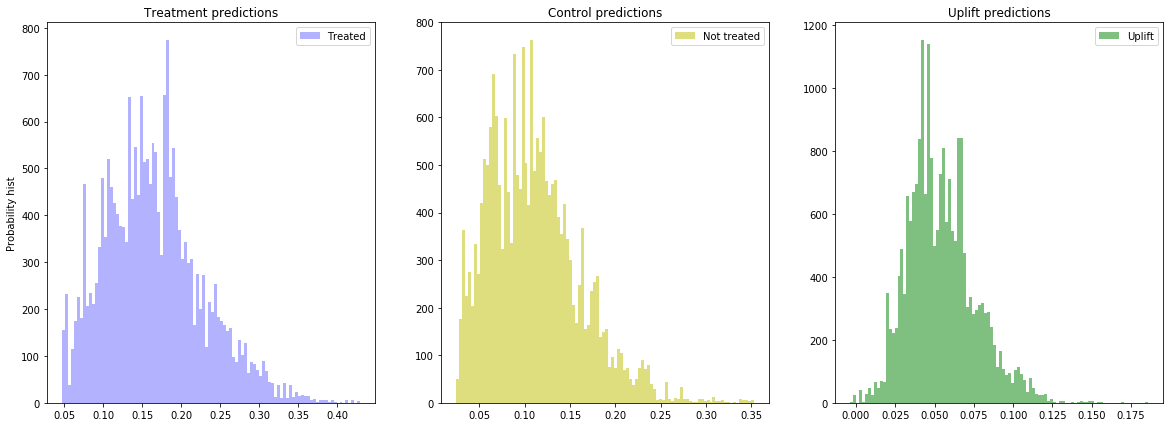

In [7]:
cat_features = ['zip_code', 'channel']
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, X_train[treat], estimator_fit_params={'cat_features': cat_features})
uplift_sm = sm.predict(X_test)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test[treat], strategy='by_group', k=0.2)
sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=X_test[treat], strategy='by_group', k=0.1)

print(f'uplift@20%: {sm_score_20:.4f}')
print(f'uplift@10%: {sm_score_10:.4f}')
models_results['SoloModel'].append(f'uplift@20%: {sm_score_20:.4f}')
models_results['SoloModel'].append(f'uplift@10%: {sm_score_10:.4f}')
sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [8]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, X_train[treat], estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test[treat], strategy='by_group', k=0.2)
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=X_test[treat], strategy='by_group', k=0.1)
models_results['ClassTransformation'].append(f'uplift@20%: {ct_score_20}')
models_results['ClassTransformation'].append(f'uplift@10%: {ct_score_10}')
models_results

C:\Users\Gar\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  """


{'SoloModel': ['uplift@20%: 0.1066', 'uplift@10%: 0.1089'],
 'ClassTransformation': ['uplift@20%: 0.22617839984381258',
  'uplift@10%: 0.274634459652641']}

In [9]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train[target], X_train[treat])

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=X_test[treat], strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/target/target_converter.cpp:394: NaN values are not supported for target

In [10]:
pd.DataFrame.from_dict(models_results)

,SoloModel,ClassTransformation
0,uplift@20%: 0.1066,uplift@20%: 0.22617839984381258
1,uplift@10%: 0.1089,uplift@10%: 0.274634459652641


С двумя моделями не очень получилось, вроде бы ошибка понятная и находится на поверхности, но я исправить так и не смог. Даже найти причину. Если сможете подсказать, буду благодарен. 